# Sign Language Detection Using Action Recognition

Using Nicholas Renotte's [Sign Language Detection using ACTION RECOGNITION with Python | LSTM Deep Learning Model](https://youtu.be/doDUihpj6ro) tutorial

[NR's code on GitHub](https://github.com/nicknochnack/ActionDetectionforSignLanguage)

## Goal: Real-time sign language detection using sequences

1. Estract holistic keypoints
2. Train an LSTM DL model
3. Make real-time predictions using sesquences

We will use:
* __media-pipe holistic__ to extract __keypoints__ from hand, body, face
* __TensorFlow__ and __Keras__ to build up a __long short-term memory deep learning model__ (__LSTM DL__) for predictions

## How it works

1. collect keypoints from mediapipe holistic
2. train a deep neural network with LSTM layers for sequences
3. perform real-time sign language detection using OpenCV

## 1. Install and import dependencies

In [ ]:
!pip install tensorflow opencv-python mediapipe sklearn matplotlib
# not installing tensorflow-gpu since I'm not using GPU

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

## 2. Find and view keypoints using MediaPipe (MP) holistic

We will be using the mediapipe package to create the following variables:

* __mp_holistic__ will be used to make our detections
* __mp_drawing__ will be used to draw our detections

In [2]:
mp_holistic = mp.solutions.holistic # holistic model
mp_drawing = mp.solutions.drawing_utils # drawing utilities

In [3]:
# mediapipe_detection(image, model) will find the mediapipe landmarks for an image
# image: the image from the feed we will be scrutinizing
# model: the MP detection model
def mediapipe_detection(image, model):
    # convert color from BGR (cv) to RGB (for mp detection)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # make image unwriteable to save memory
    image.flags.writeable = False
    # make prediction using the MP detection model
    results = model.process(image)
    # make image writeable again
    image.flags.writeable = True
    # convert image back to BGR
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

In [ ]:
# FYI: for information on the cv2.cvtColor() function
cv2.cvtColor??

In [4]:
# draw_landmarks(image, results) will draw the landmark points over the live image
# image: the image from the feed we will be drawing on top of
# results: the landmark list we found with mediapipe_detection()
def draw_landmarks(image, results):
    # draw face landmarks & connections
    # no longer use FACE_CONNECTIONS.  Rather, use FACEMESH_TESSELATION
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION)
    # draw pose landmarks & connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)
    # draw left hand landmarks & connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    # draw right hand landmarks & connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    

In [ ]:
# FYI: media pipe's documentation on mp_drawing.draw_landmarks
# (mp.solutions.drawing_utils.draw_landmarks)
mp_drawing.draw_landmarks??

In [ ]:
# shows what landmark is connected to what landmark
# nose = 0, 1 = inner left eye, 4 = inner right eye, 2 = left eye, 3 = outer left eye
mp_holistic.POSE_CONNECTIONS

In [5]:
cap = cv2.VideoCapture(2) # 2 is for logitech (near right USB-C port)
# set the mediapipe model
with mp_holistic.Holistic(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as holistic:
    while cap.isOpened():
        #read feed
        ret, frame = cap.read()
        #make detection
        image, results = mediapipe_detection(frame, holistic)
        #draw landmarks and connections
        draw_landmarks(image, results)
        # show to screen
        cv2.imshow('OpenCV Feed', image)
        #break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    # end the video capture setting
    cap.release()
    cv2.waitKey(1)
    # close the video capture window(s)
    cv2.destroyAllWindows()
    cv2.waitKey(1)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [ ]:
#this will show the number of landmark points of the left hand in the ending frame.
len(results.face_landmarks.landmark)

In [ ]:
draw_landmarks(frame, results)

In [ ]:
# plot the last frame from the frame array
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [ ]:
results.face_landmarks

In [ ]:
frame[:2]

In [ ]:
# data points for image detection vs landmark detection
print('one frame... ', 'image:', len(frame) * len(frame[0]) * 16 * 2, 'landmark:', 468 * 3 * 16 * 2)
print('two seconds @ 15fps... ', 'image:', len(frame) * len(frame[0]) * 16 * 2, 'landmark:', 468 * 3 * 16 * 2)

## 3. Extract keypoint values

### input data

The input data used for this action detection model is a series of __30 arrays__.  __Each__ array contains __1662 values__ (30, 1662).

__Each__ array represents a __single frame__'s the landmark values (1662 values).

We will be using __30 frames of action__ to train and test on.

Typical landmarks will look like this:
<div>
    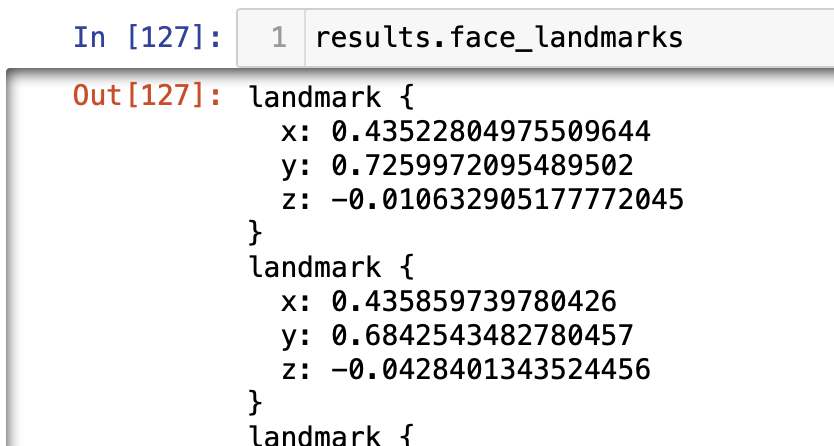
</div>
* We will concatenate the landmarks into a numpy array.
* If there are no landmarks then we will return a numpy 0 array.

In [ ]:
pose = []
for res in results.pose_landmarks.landmark:
    landmark_data = np.array([res.x, res.y, res.z, res.visibility])
    pose.append(landmark_data)

In [6]:
# rewrite above code onto one line:
pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark])


In [ ]:
len(pose) # should be 33 since there are 33 mp pose landmarks

In [ ]:
pose[:5]

In [ ]:
pose.shape

In [ ]:
pose.flatten()

In [ ]:
pose.flatten().shape

In [7]:
# save the number of mp landmarks for:
# facemesh, pose, left hand, right hand
# numbers found in MP documentation
num_mp_lmks = {
    'face' : {'num' : 468, 'dim' : 3}, # dim: x,y,z
    'pose' : {'num' : 33, 'dim' : 4}, # dim: x,y,z,visibility
    'hand' : {'num' : 21, 'dim' : 3} # dim: x,y,z
}
# add total by multiplying number of landmarks w/ their dimensions
for v in num_mp_lmks.values():
    v['total'] = (v['num'] * v['dim'])

In [ ]:
num_mp_lmks

In [ ]:
len(np.zeros(num_mp_lmks['pose']['total']))

In [8]:
pose = np.array([[res.x, res.y, res.z, res.visibility]\
        for res in results.pose_landmarks.landmark]).flatten()\
        if results.pose_landmarks\
        else np.zeros(num_mp_lmks['pose']['total'])

face = np.array([[res.x, res.y, res.z]\
        for res in results.face_landmarks.landmark]).flatten()\
        if results.face_landmarks\
        else np.zeros(num_mp_lmks['face']['total'])

lhand = np.array([[res.x, res.y, res.z]\
        for res in results.pose_landmarks.landmark]).flatten()\
        if results.left_hand_landmarks\
        else np.zeros(num_mp_lmks['hand']['total'])

rhand = np.array([[res.x, res.y, res.z]\
        for res in results.pose_landmarks.landmark]).flatten()\
        if results.right_hand_landmarks\
        else np.zeros(num_mp_lmks['hand']['total'])


In [ ]:
len(pose)

In [ ]:
len(face)

In [ ]:
len(lhand)

In [ ]:
len(rhand)

In [9]:
# extract_keypoints(results)
# returns a single array with every single keypoint value in a frame
#results are the media pipe detection results

def extract_keypoints(results):
    if results.pose_landmarks:
        pose = np.array([[res.x, res.y, res.z, res.visibility]\
            for res in results.pose_landmarks.landmark]).flatten()
    else:
        pose = np.zeros(num_mp_lmks['pose']['total'])
    
    if results.face_landmarks:
        face = np.array([[res.x, res.y, res.z]\
            for res in results.face_landmarks.landmark]).flatten()
    else:
        face = np.zeros(num_mp_lmks['face']['total'])

    if results.left_hand_landmarks:
        lhand = np.array([[res.x, res.y, res.z]\
            for res in results.left_hand_landmarks.landmark]).flatten()
    else:
        lhand = np.zeros(num_mp_lmks['hand']['total'])

    if results.right_hand_landmarks:
        rhand = np.array([[res.x, res.y, res.z]\
            for res in results.right_hand_landmarks.landmark]).flatten()
    else:
        rhand = np.zeros(num_mp_lmks['hand']['total'])

    return np.concatenate([pose, face, lhand, rhand])

In [ ]:
extract_keypoints(results)[:10]

## 4. Set up folders for collection

In [10]:
# path for exported data, numpy arrays
DATA_PATH = os.path.join('ASL', 'MP_Data')

# actions that we try to detect
actions = np.array(['hello', 'thanks', 'iloveyou'])

# 25 videos worth of data per action
# num_sequences = 25
num_sequences = 25

#videos will be 30 frames in length
sequence_length = 30

In [ ]:
# create folders
# 1 folder per action
# 1 folder per sequence
# 30 frames worth od data will be in each sequence folder

for action in actions:
    for sequence in range(num_sequences):
        try:
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

## 5. Collect keypoint values for training and testing

In [ ]:
# my test array
result_test = extract_keypoints(results)
result_test

In [ ]:
# save this test array to disk
np.save('test_results', result_test)

In [ ]:
# load the test array
np.load('test_results.npy')

In [ ]:
cap = cv2.VideoCapture(2) # 2 is for logitech (near right USB-C port)
# set the mediapipe model
with mp_holistic.Holistic(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as holistic:
    # loop through actions
    for action in actions:
        # loop through sequences (aka videos)
        for sequence in range(num_sequences):
            # loop through video length (aka sequence length)
            for frame_num in range(sequence_length):
                
                #read feed
                ret, frame = cap.read()
                
                #make detection
                image, results = mediapipe_detection(frame, holistic)
                
                #draw landmarks and connections
                draw_landmarks(image, results)
                
                #collection pauses and messaging
                if frame_num == 0:
                    cv2.putText(frame, ('STARTING {} IN 2 SECONDS!'.format(action)),
                                (120,200), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,150,0), 2, cv2.LINE_AA)
                    cv2.putText(frame, ('Collecting frames for {} Video Number {}'.format(action, sequence)),
                                (30,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,150), 1, cv2.LINE_AA)
                    # show to screen
                    cv2.imshow('OpenCV Feed', frame)
                    cv2.waitKey(2000)
                else:
                    cv2.putText(frame, ('Collecting frames for {} Video Number {}'.format(action, sequence)),
                                (30,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,150), 1, cv2.LINE_AA)
                    # show to screen
                    cv2.imshow('OpenCV Feed', frame)
                
                #export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)
                
                #break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                # end video capture
    cap.release()
    cv2.waitKey(1)
    # close the video capture window(s)
    cv2.destroyAllWindows()
    cv2.waitKey(1)

In [ ]:
cap.release()
cv2.waitKey(1)
# close the video capture window(s)
cv2.destroyAllWindows()
cv2.waitKey(1)

## 6. Pre-process data and create labels and features

__sequences__ (__videos__) are going to represent our __feature data__ (aka __x-data__)
__labels__ (is the video hello, thanks or iloveyou) represents our __y-data__

We are going to use our features (sequences or videos) to __train__ a model to represent the __relationship__ between the __features__ and the __labels__.

In [11]:
# import dependencies
from sklearn.model_selection import train_test_split
#helps us split up data for testing and training

from tensorflow.keras.utils import to_categorical
# to convert an np array of values to np array of 0s, 1s

In [ ]:
print(actions)

In [12]:
label_map = {label : num for num, label in enumerate(actions)}

In [14]:
label_map

{'hello': 0, 'thanks': 1, 'iloveyou': 2}

In [13]:
# bring in the saved data
sequences, labels = [],[] #empty arrays. Think of sequences as x-data, label as y-data
for action in actions:
    for seq in range(num_sequences):
        window = [] # all of the frames for this sequence
        for frame_num in range(sequence_length):
            result = np.load(os.path.join(DATA_PATH, action, str(seq), '{}.npy'.format(frame_num)))
            window.append(result)
        sequences.append(window)
        labels.append(label_map[action])

In [15]:
np.shape(sequences)

(75, 30, 1662)

In [16]:
np.shape(labels)

(75,)

In [17]:
x = np.array(sequences) # make a numpy array from sequences

In [18]:
sequences

[[array([ 0.44138631,  0.60108995, -1.12835491, ...,  0.        ,
          0.        ,  0.        ]),
  array([ 0.44121972,  0.52195168, -0.57821298, ...,  0.        ,
          0.        ,  0.        ]),
  array([ 0.44093838,  0.4919728 , -0.50499684, ...,  0.        ,
          0.        ,  0.        ]),
  array([ 0.4408533 ,  0.48721889, -0.52490783, ...,  0.        ,
          0.        ,  0.        ]),
  array([ 0.4394891 ,  0.48536903, -0.50781649, ...,  0.        ,
          0.        ,  0.        ]),
  array([ 0.43747428,  0.49241713, -0.50817031, ...,  0.        ,
          0.        ,  0.        ]),
  array([ 0.43619412,  0.49606898, -0.519467  , ...,  0.        ,
          0.        ,  0.        ]),
  array([ 0.43522874,  0.4991186 , -0.49879789, ...,  0.        ,
          0.        ,  0.        ]),
  array([ 0.43492386,  0.50103813, -0.45575058, ...,  0.        ,
          0.        ,  0.        ]),
  array([ 0.43503794,  0.50287718, -0.42033774, ...,  0.        ,
       

In [19]:
x

array([[[ 0.44138631,  0.60108995, -1.12835491, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.44121972,  0.52195168, -0.57821298, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.44093838,  0.4919728 , -0.50499684, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.43103504,  0.47624123, -0.58562988, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.43131414,  0.4774996 , -0.5392434 , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.43232313,  0.47838548, -0.53834665, ...,  0.        ,
          0.        ,  0.        ]],

       [[ 0.43258455,  0.47883555, -0.5378204 , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.44358197,  0.47776169, -0.55569804, ...,  0.12964603,
          0.52221841, -0.01776789],
        [ 0.44657746,  0.47583082, -0.55405372, ...,  0.15771393,
          0.46360639,  0.00965701],
        ...,
        [ 0.49519533,  0.48109221, -0.55869883, ...,  

In [20]:
np.shape(x)

(75, 30, 1662)

In [21]:
labels # it's a vector with values either 0, 1, or 2

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2]

In [22]:
np.shape(labels)

(75,)

In [23]:
# change (75,) label vector w values of 0,1,2 to (3,) category vector
# where 1 is either in cell[0], cell[1], or cell[2]
# basically a binary flag
# i.e. label value = 2 --> category value = [0, 0, 1]
y = to_categorical(labels).astype(int)

In [24]:
y

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0,

In [ ]:
y[24]

In [ ]:
y[49]

In [ ]:
y[74]

In [25]:
np.shape(y)

(75, 3)

### split our data into training and testing
__train_test_split()__ will make a __random__ selection each time

In [26]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.06) #6% will be test data

In [27]:
y_test

array([[0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]])

In [ ]:
len(x_test)

In [ ]:
len(y_test)

## 7. Build and train LSTM neural network
__LSTM__: Long short-term memory

We're going to pass 30 frames with 1662 keyframes each.
We will then pre-process the result and extract the action.

In [28]:
# import required packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [29]:
# set up the log path to then view the log with TensorBoard
LOG_DIR = os.path.join('ASL', 'logs')
tb_callback = TensorBoard(log_dir = LOG_DIR)

<a id="model_rebuild"></a>
### Build or rebuild the model
This is the model's shape
When [loading a model](#load_model) from disk, make sure to:
1. run this model rebuild first
2. [compile](#compile_model) the model
3. then you can load [load the model](#load_model)

In [30]:
# instantiate the Sequential API model
model = Sequential()

# creating the LSTM layers
# 1st layer: 64 LSTM units, return sequence (True) so next layer can use it
# shape of each sequence (video) is 30 frames by 1662 keypoints (30,1662)
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))

# 2nd layer: 128 LSTM units
model.add(LSTM(128, return_sequences=True, activation='relu'))

#3rd layer: 64 LSTM units, won't be returning the sequence
model.add(LSTM(64, return_sequences=False, activation='relu'))

# creating the Dense layers
# 1st layer: 64 Densly connected Neural Network neurons
model.add(Dense(64, activation='relu'))

#2nd layer: 32 Dense NN neurons
model.add(Dense(32, activation='relu'))

# create the Actions layer
# 3 neural network units (actions.shape = (3,) and so actions.shape[0] = 3)
# choosing softmax because all three values in the model will add up to 1
model.add(Dense(actions.shape[0], activation='softmax'))

2022-09-16 10:18:39.874202: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
x.shape

In [ ]:
actions.shape

In [ ]:
actions.shape[0]  # 3 neural network units

In [ ]:
#softmax result example
res = [.7, .2, .1]
#rounds to: [1, 0, 0]
#label inference result is "hello"
np.argmax(res) # "hello"

In [ ]:
actions[np.argmax(res)]

In [ ]:
res2 = [.3, .6, .1]
np.argmax(res2) # "thanks"

In [ ]:
actions[np.argmax(res2)]

<a id="compile_model"></a>
### compile the model
After you have defined the model's shape, you will need to compile the model.

When [loading a model](#load_model) from disk, make sure to:
1. run the [model rebuild](#model_rebuild) first
2. Run this model compiler
3. then you can load [load the model](#load_model)

In [31]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])


### train the model

In [ ]:
model.fit(x_train, y_train, epochs=2000, callbacks=[tb_callback])

In [ ]:
model.summary()

## 8. Make predictions
Make 
__predictions__ on __x_test__ and __compare__ them to the __correct answers__ in __y_test__

In [ ]:
# this is our test data
x_test[:2]

In [ ]:
# use the model to predict what our test data is
res3 = model.predict(x_test)

In [ ]:
# test results as category arrays
# each test unit result is an array of probabilities that add up to one
# the one with the highest probability is the prediction
res3

In [ ]:
res3[0]

In [ ]:
np.sum(res3[0])

In [ ]:
actions

In [ ]:
for i in range(len(res3)):
    print(actions[np.argmax(res3[i])])

In [ ]:
# match our predictions with the actual results:
#accurate!!
y_test

## 9. Save weights (aka model)

In [ ]:
model

In [ ]:
# save the model I trained
model.save(os.path.join('ASL', 'my_first_action_model.h5'))

In [ ]:
# now I can delete the model
del model

<a id="load_model"></a>
### reload steps:
1. run the [model rebuild](#model_rebuild)
2. [compile](#compile) the data
3. reload model

In [32]:
model.load_weights(os.path.join('ASL', 'my_first_action_model.h5'))

In [33]:
model

## 10. Evaluation using confusion matrix and accuracy

In [ ]:
### TBD ###

## 11. Test in Real Time

In [38]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (10,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (10, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (50,100,100), 2, cv2.LINE_AA)
        
    return output_frame

In [37]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))

NameError: name 'res' is not defined

<Figure size 1800x1800 with 0 Axes>

In [43]:
# 1. Three new detection variables
sequence = [] #to collect our 30 frames. Once we get 30 frames we will start predicting
sentence = [] #concatenate our history of detections together
threshold = 0.8 #render results only if above a certain threshold

cap = cv2.VideoCapture(2) # 2 is for logitech (near right USB-C port)
# set the mediapipe model
with mp_holistic.Holistic(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as holistic:
    while cap.isOpened():
        
        #read feed
        ret, frame = cap.read()
        
        #make detection
        image, results = mediapipe_detection(frame, holistic)
        
        #draw landmarks and connections
        draw_landmarks(image, results)
        
        # show to screen
        cv2.imshow('OpenCV Feed', image)
        
        #break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
            
    # end the video capture setting
    cap.release()
    cv2.waitKey(1)
    # close the video capture window(s)
    cv2.destroyAllWindows()
    cv2.waitKey(1)

In [40]:
np.expand_dims(x_test[0], axis=0)

array([[[ 0.45602491,  0.45565483, -0.52416241, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.44255108,  0.45421612, -0.64772576, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.43666407,  0.45423889, -0.67086917, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.42140189,  0.4590925 , -0.55821216, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.4213331 ,  0.45916995, -0.56725442, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.42084929,  0.45999563, -0.5738799 , ...,  0.        ,
          0.        ,  0.        ]]])

In [41]:
model.predict(np.expand_dims(x_test[0], axis=0))

1/1 [==============================] - 0s 403ms/step


array([[0.00000e+00, 1.00000e+00, 4.41814e-28]], dtype=float32)

In [104]:
# 1. Three new detection variables
sequence = [] #to collect our 30 frames. Once we get 30 frames we will start predicting
sentence = [] #concatenate our history of detections together
threshold = 0.5 #render results only if above a certain threshold

cap = cv2.VideoCapture(2) # 2 is for logitech (near right USB-C port)
# set the mediapipe model
with mp_holistic.Holistic(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as holistic:
    while cap.isOpened():
        
        #read feed
        ret, frame = cap.read()
        
        #make detection
        image, results = mediapipe_detection(frame, holistic)
        
        #draw landmarks and connections
        draw_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            predictions.append(np.argmax(res))
            
        # 3. Vis logic
        if res[np.argmax(res)] > threshold: # checking if result is above our threshold
            if len(sentence) > 0: 
                if actions[np.argmax(res)] != sentence[-1]:
                    sentence.append(actions[np.argmax(res)])
            else:
                sentence.append(actions[np.argmax(res)])

                    
        if len(sentence) > 5:
            sentence = sentence[-5:]
            
        cv2.rectangle(image, (0,0), (640,40), (245, 17, 16), -1)
        cv2.putText(image, ' {}'.format(sentence[-1]), (3,30),
                   cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        
        # show to screen
        cv2.imshow('OpenCV Feed', image)
        
        #break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
            
    # end the video capture setting
    cap.release()
    cv2.waitKey(1)
    # close the video capture window(s)
    cv2.destroyAllWindows()
    cv2.waitKey(1)

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 20ms/step


In [103]:
    # end the video capture setting
    cap.release()
    cv2.waitKey(1)
    # close the video capture window(s)
    cv2.destroyAllWindows()
    cv2.waitKey(1)

-1